# `contextily`

In [1]:
%matplotlib inline

import contextily as ctx
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# Data
from pysal.examples import get_path

/home/danie/miniconda3/envs/gds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/danie/miniconda3/envs/gds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/danie/miniconda3/envs/gds/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In this notebook, we will show the basic functionality available in `contextily`, a package to work with web-tiles for background maps. To do that, we will use additional data to illustrate `contextily` can be integrated with other libraries such as `geopandas` and `rasterio`. However, it is important to note that some of those are **NOT** required by `contextily`.

Let us first load up from `PySAL` the polygons of the 48 contiguous states using `geopandas`. We'll pick out Texas and, since our data is not projected by default, set its [default coordinate reference system](http://spatialreference.org/ref/epsg/4326/).

To do this:

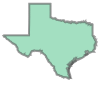

In [2]:
tx = gpd.read_file(get_path('us48.shp')).set_index('STATE_ABBR').loc[['TX'], 'geometry']
tx.crs = {'init': 'epsg:4326'}
tx['TX']

We can get the bounding box from the polygon itself:

In [3]:
w, s, e, n = tx['TX'].bounds
w, s, e, n

(-106.6495132446289, 25.845197677612305, -93.50721740722656, 36.49387741088867)

Or, if we had a geodataframe with many elements, we could also get the total bounding box for all elements in the frame:

In [4]:
w, s, e, n = tx.total_bounds
w, s, e, n

(-106.6495132446289, 25.845197677612305, -93.50721740722656, 36.49387741088867)

## Simplified plotting

The simplest way to access `contextily` and get a background map to go with your geographic data is to use the `add_basemap` method. Assuming you have a `GeoDataFrame` (such as `tx`) and is projected to Web Mercator (`EPSG`= 3857), you can simply:

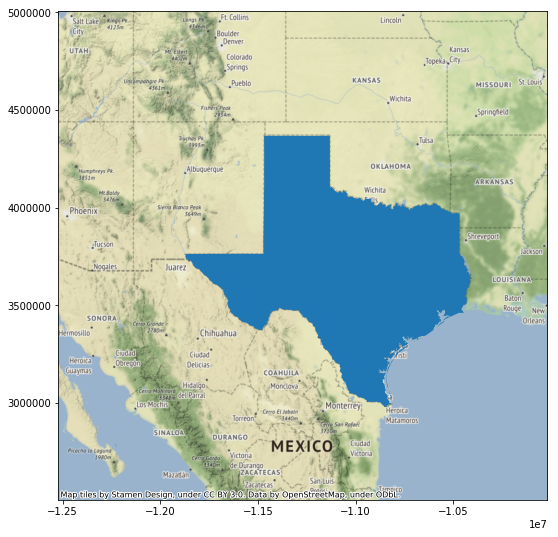

In [5]:
ax = tx.to_crs(epsg=3857).plot(figsize=(9, 9))
ctx.add_basemap(ax);

## Download tiles

At this point, we can use those bounds to download the tiles for that part of the world. Before that, however, it is convenient to make sure the download will not be too heavy (i.e. not too many tiles). This is easily checked by using the `howmany` utility:

In [6]:
_ = ctx.howmany(w, s, e, n, 6, ll=True)

Using zoom level 6, this will download 9 tiles


At the zoom level 6, we need to download 9 tiles, which is not too onerous. Let us then go ahead and download them:

In [7]:
%time img, ext = ctx.bounds2img(w, s, e, n, 6, ll=True)

CPU times: user 46.9 ms, sys: 46.9 ms, total: 93.8 ms
Wall time: 813 ms


That's it! Just under three seconds and we have a map under our fingertips! Note how `bounds2img` also returns the extent that the tile covers. This will come in handy later on when we want to align it with more data.

**IMPORTANT**: the tile extent is always returned in Spherical Mercator (EPSG:3857). This means that the data you want to map (like ours in `tx`) may have a different projection than that returned from `bounds2img`. 

Let us quickly visualize it with `matplotlib`:

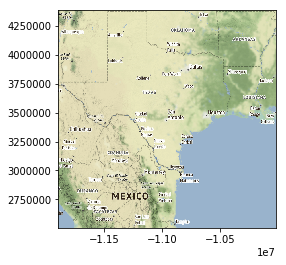

In [8]:
plt.imshow(img, extent=ext);

## Save tiles into raster files

Sometimes, we know we will be working with an area for a while and it is more convenient to download the tiles only once and then load them up on-demand. To do that, we can use the function `bounds2raster`, which writes the image into a GeoTIFF raster file:

In [9]:
%time _ = ctx.bounds2raster(w, s, e, n, 'tx.tif', ll=True)

CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 145 ms


## Search for tiles with text
You can also directly search for tiles using the `Place` class. This allows you to search with text. It will grab the tiles associated with that search (using GeoPy geocoding) so that you can plot them.

In [10]:
zoom=7
loc = ctx.Place("texas", zoom=zoom)

/home/danie/miniconda3/envs/gds/lib/python3.6/site-packages/geopy/geocoders/osm.py:138: UserWarning: Using Nominatim with the default "geopy/1.16.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


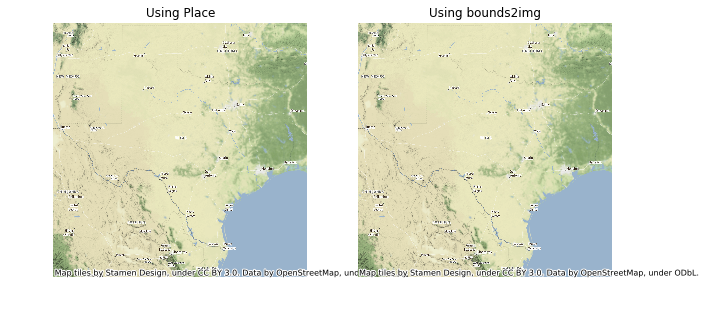

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Grab the image associated with this search and plot it
ctx.plot_map(loc.im, ax=axs[0], title='Using Place')

# Manually find this tile using the Place's bounds
zoom = ctx.tile._calculate_zoom(loc.w, loc.s, loc.e, loc.n)
im2, bbox = ctx.bounds2img(loc.w, loc.s, loc.e, loc.n, zoom=zoom, ll=True)
ctx.plot_map(im2, bbox, ax=axs[1], title='Using bounds2img')

plt.show()

## Read raster tiles and combine with vector data

At this point, using the tile map is exactly the same as using any other raster file. For this, we will use the fantastic library `rasterio`. 

Let us see how we can load it back up and plot it (all of this is standard `rasterio` operations, check out its [documentation](https://mapbox.github.io/rasterio/) for more detail if interested).

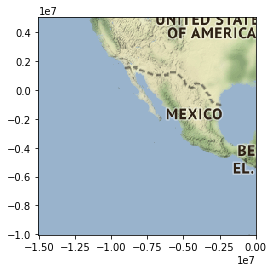

In [12]:
rtr = rio.open('tx.tif')

# NOTE the transpose of the image data
img = np.array([ band for band in rtr.read() ]).transpose(1, 2, 0)
# Plot
plt.imshow(img, extent=rtr.bounds);

Sometimes, raster files can be (very) large and we are not particularly interested in loading the entire file. For those cases, `rasterio` includes functionality to load up a specific part -window- of the raster. The function `bb2wdw` in `contextily` makes it easy to create that window from Mercator coordinates:

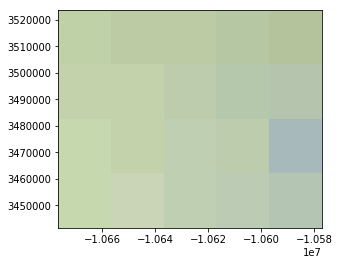

In [13]:
# Mercator coordinates for Houston area
hou = (-10676650.69219051, 3441477.046670125, -10576977.7804825, 3523606.146650609)

# Window
wdw = ctx.tile.bb2wdw(hou, rtr)
# Raster subset
sub = np.array([ rtr.read(band, window=wdw) \
      for band in range(1, rtr.count+1)]).transpose(1, 2, 0)
# Plot
plt.imshow(sub, extent=(hou[0], hou[2], hou[1], hou[3]));

## Combine layers

One of the most interesting applications of using these tiles is to employ them as basemaps to overlay additional data on top of them. This can be easily done with `matplotlib`, provided all the data are in the same CRS at the time of plotting.

Let us see how one would go about plotting the polygon for the state of Texas on top of the raster file:

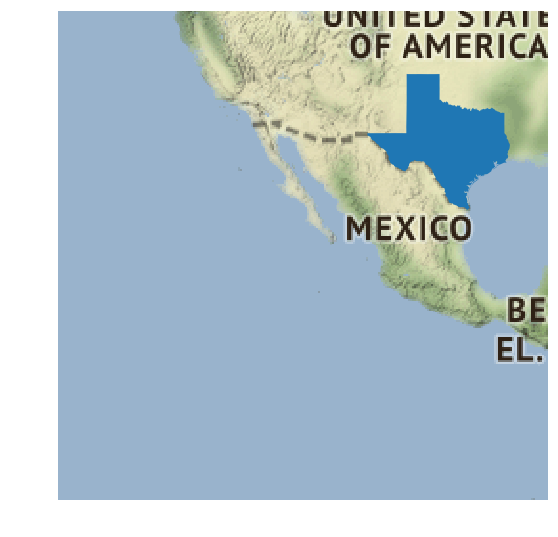

In [14]:
# Shortify the bound box named tuple
bb = rtr.bounds
# Set up the figure
f, ax = plt.subplots(1, figsize=(9, 9))
# Load the tile raster (note the re-arrangement of the bounds)
ax.imshow(img, extent=(bb.left, bb.right, bb.bottom, bb.top))
# Overlay the polygon on top (note we reproject it to the raster's CRS)
tx.to_crs(rtr.crs).plot(edgecolor='none', ax=ax)
# Remove axis for aesthetics
ax.set_axis_off()
# Show
plt.show()

If we remember that our tiles are served in Spherical Mercator projection, we can also plot without saving our tiles to a file:

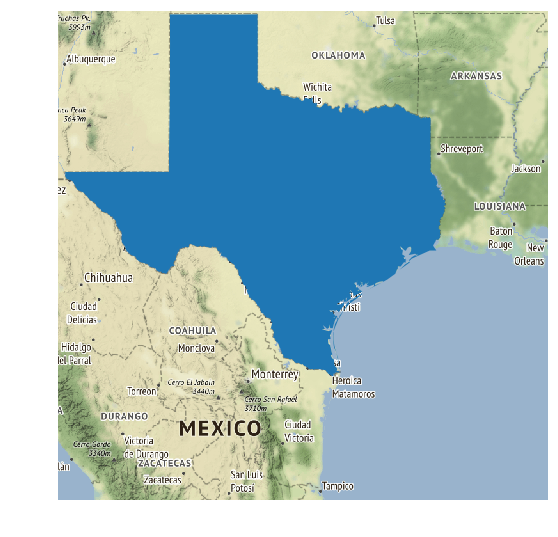

In [15]:
#fetch image using the bounding box:
image, extent = ctx.bounds2img(w, s, e, n, 6, ll=True)
# Set up the figure
f,ax = plt.subplots(1, figsize=(9,9))
# Load the tile raster 
# (note that the extent returned by bounds2img
# corresponds directly to matplotlib bounds)
ax.imshow(image, extent=extent)
# Overlay the polygon on top 
# Note we reproject the vector to webmercator, which has an epsg code of 3857
tx.to_crs(epsg=3857).plot(edgecolor='none', ax=ax)
# Remove axis for aesthetics
ax.set_axis_off()
# Show
plt.show()

## Different backgrounds

`contextily` gives access to several tile maps, all from the awesome people at [Stamen](http://stamen.com). The full list is:

In [16]:
sources = [i for i in dir(ctx.tile_providers) if i[0]!='_']
sources

['OSM_A',
 'OSM_B',
 'OSM_C',
 'ST_TERRAIN',
 'ST_TERRAIN_BACKGROUND',
 'ST_TERRAIN_LABELS',
 'ST_TERRAIN_LINES',
 'ST_TONER',
 'ST_TONER_BACKGROUND',
 'ST_TONER_HYBRID',
 'ST_TONER_LABELS',
 'ST_TONER_LINES',
 'ST_TONER_LITE',
 'ST_WATERCOLOR']

You can set them on `bounds2img` and `bounds2raster` using the argument `url`. Checkout the documentation for more details.

Just because we can, let us get a feel for what they look like:

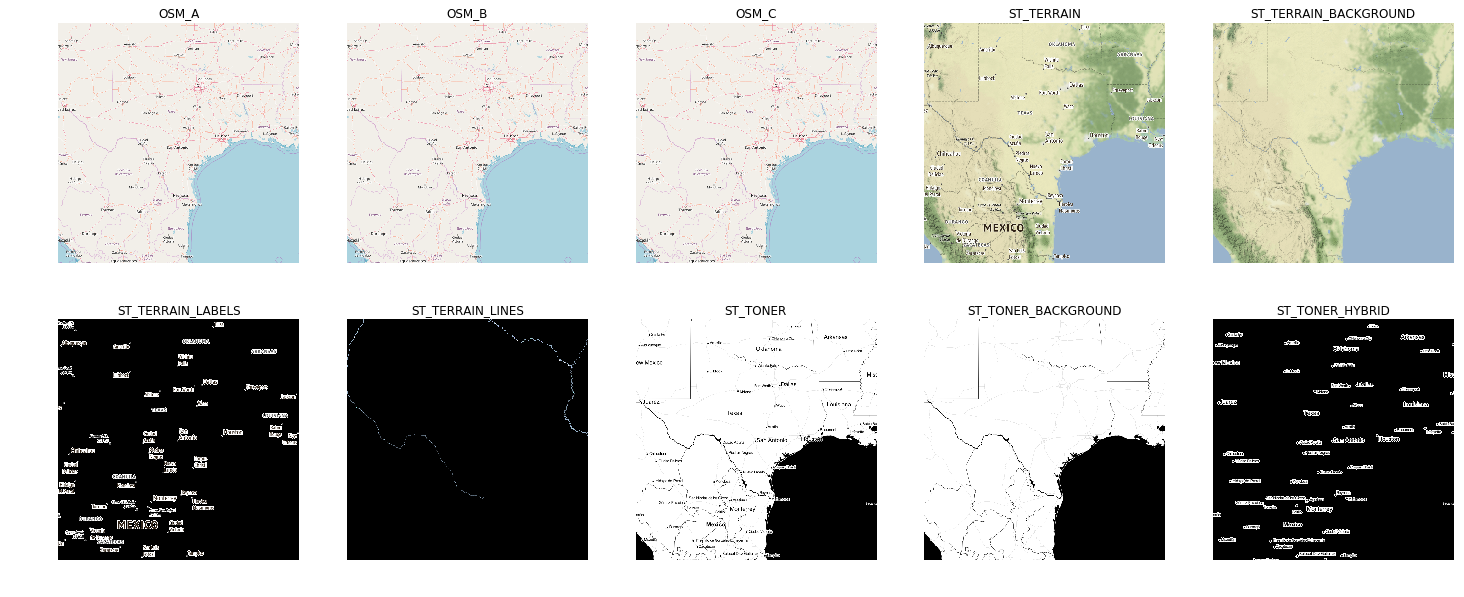

In [17]:
f, axs = plt.subplots(2, 5, figsize=(25, 10))
axs = axs.flatten()
for src, ax in zip(sources, axs):
    img, ext = ctx.bounds2img(w, s, e, n, 6, url=getattr(ctx.sources, src), ll=True)
    ax.imshow(img, extent=ext)
    ax.set_title(src)
    ax.set_axis_off()
plt.show()

**NOTE** Please always remember to give proper attribution to the map provider. See [here](http://maps.stamen.com/#watercolor/12/37.7706/-122.3782) for the proper way to do it, but essentially it is:

* Toner and Terrain: 

> Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.

* Watercolor:

> Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://creativecommons.org/licenses/by-sa/3.0">CC BY SA</a>.